# Programando la Máquina de Soporte Vectorial Cuántica

Como mencionamos anteriormente, la eficacia de las máquinas de soporte vectorial radica en el hecho de encontrar el hiperplano de separación entre dos conjuntos originalmente no linealmente separables, utilizando funciones kernel. En esta sección, desarrollaremos un ejercicio de aprendizaje supervisado utilizando la versión clásica y la cuántica de este algoritmo, con el objetivo de determinar si existe alguna ventaja cuántica. 

## Máquina de Soporte Vectorial Clásica

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [2]:
dataframe = pd.read_csv('C:\\Users\\leon-\\Documents\\Otoño 2021\\Quantum Computing\\QSVM\\Heart\\heart.csv')
dataframe

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


A continuación, de los 303 datos que se tienen, contamos cuántos hay de cada caso.

output
0    138
1    165
dtype: int64


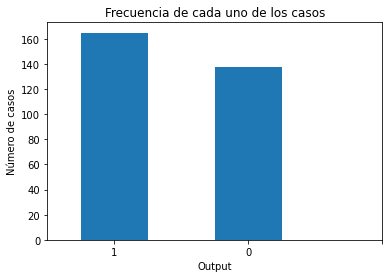

In [3]:
print(dataframe.groupby('output').size())
clases = pd.value_counts(dataframe['output'], sort = True)
clases.plot(kind = 'bar', rot=0)
plt.xticks(range(3))
plt.title("Frecuencia de cada uno de los casos")
plt.xlabel("Output")
plt.ylabel("Número de casos");

Separamos el vector de etiquetas de las demás columnas, así como dividimos el set de datos en 80% y 20% para el conjunto de entrenamiento y prueba, respectivamente.

In [4]:
X = np.array(dataframe.drop(['output'],1))
Output = np.array(dataframe['output'])

In [5]:
entrenamiento, prueba, entrenamiento_tag, prueba_tag = train_test_split(
     X, Output, test_size=0.2, random_state=22)
print('Datos del entrenamiento: ',entrenamiento.shape)
print('Datos de la prueba: ',prueba.shape)

Datos del entrenamiento:  (242, 13)
Datos de la prueba:  (61, 13)


In [6]:
entrenamiento

array([[58.,  1.,  1., ...,  1.,  4.,  3.],
       [44.,  1.,  2., ...,  2.,  0.,  2.],
       [49.,  0.,  1., ...,  1.,  0.,  2.],
       ...,
       [42.,  0.,  0., ...,  1.,  0.,  2.],
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [42.,  1.,  1., ...,  2.,  0.,  2.]])

In [7]:
#Reducir dimensiones
#n_dim = 4
#pca = PCA(n_components=n_dim).fit(X)
#sample_train = pca.transform(sample_train)
#sample_test = pca.transform(sample_test)

En la siguientes líneas, escalamos, normalizamos y cortamos nuestros datos.

In [8]:
escala = StandardScaler().fit(entrenamiento)
entrenamiento = escala.transform(entrenamiento)
prueba = escala.transform(prueba)

samples = np.append(entrenamiento, prueba, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
entrenamiento = minmax_scale.transform(entrenamiento)
prueba = minmax_scale.transform(prueba)

In [9]:
entrenamiento_size = 100
entrenamiento = entrenamiento[:entrenamiento_size]
entrenamiento_tag= entrenamiento_tag[:entrenamiento_size]

prueba_size = 20
prueba= prueba[:prueba_size]
prueba_tag = prueba_tag[:prueba_size]

In [10]:
i=18
print(prueba[i], prueba_tag[i])

[ 0.375       1.         -0.33333333 -0.35849057 -0.62557078  1.
 -1.          0.05343511 -1.         -1.          1.         -1.
  0.33333333] 1


In [11]:
ejemplo=prueba[i]

In [12]:
kernels_clasicos = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels_clasicos:
    svc_clasico = SVC(kernel=kernel)
    svc_clasico.fit(entrenamiento, entrenamiento_tag)
    puntuacion = svc_clasico.score(prueba, prueba_tag)
    
    sol =svc_clasico.predict([ejemplo])

    print('%s kernel classification test score:  %0.2f' % (kernel, puntuacion))
    print('Predicción: ', sol)

linear kernel classification test score:  0.80
Predicción:  [0]
poly kernel classification test score:  0.80
Predicción:  [1]
rbf kernel classification test score:  0.80
Predicción:  [0]
sigmoid kernel classification test score:  0.85
Predicción:  [1]


# Parte cuántica

Como se mencionó anteriormente, una máquina de soporte vectorial cuántica funciona de la misma forma que una clásica, con la única diferencia de que se utiliza una compuerta cuántica en un circuito a manera de transformación del espacio de entradas a un espacio de características cuántico. A saber:

$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$

Así, $$\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}$$ es el valor que tendrá cada uno de los productos escalares en el problema de maximización de $$ L(\vec{\alpha})=\sum_{i=1}^{n}\alpha_{i}-\frac{1}{2}\sum_{i,j=0}^{n}\alpha_{i}\alpha_{j}y_{i}y_{j}K(\vec{x_{i}}, \vec{x_{j}})$$.

Hay varias formas en las que se puede obtener los valores anteriores. En el que nos enfocaremos es en el de crear el circuito  $$\mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) $$ y medir la probabilidad de obtener $$| 0^{\otimes n} \rangle$$.

La compuertas más utilizadas para este propósito son las conocidas como Pauli Feature Maps, que se pueden describir como sigue: $$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right). $$

Donde $P_i \in \{ I, X, Y, Z \}$, y $S$ es un par ordenado que indica las conexiones que se necesitan para calcular $\phi_S$ : $S \in \{\binom{n}{k}\ combinaciones,\ k = 1,... n \}$. Aunque $phi_{S}$ puede variar, la usada por default es:
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$
    
Por ejemplo $k = 1, P_0 = Z$, obtenemos: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

Que es conocida como `ZFeatureMap` y biene incluida en Qiskit. 


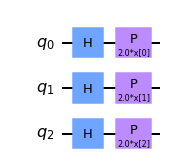

In [13]:
map_z = ZFeatureMap(feature_dimension=3, reps=1)
map_z.decompose().draw('mpl')

Teniendo en cuenta que, si $X$ es una matriz, $$e^{X}=\sum^{\inf}_{k=0}\frac{X^{k}}{k!}$$, podemos desarrollar la parte exponencial de la ecuación del mapa de características de Pauli y llegar a la compuerta fase (P) a un ángulo de $2\phi$, cuando k=1.

Un ejemplo más interesante es el mapa de características que obtenemos al hacer and $k = 2, P_0 = Z, P_1 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

Que está integrada en Qiskit como la compuerta `ZZFeatureMap` y se puede visualizar así:

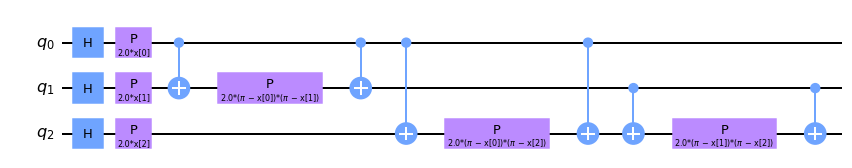

In [14]:
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw('mpl')

Un ejemplo sencillo de cómo podemos codificar información usando `ZZFeatureMap`:

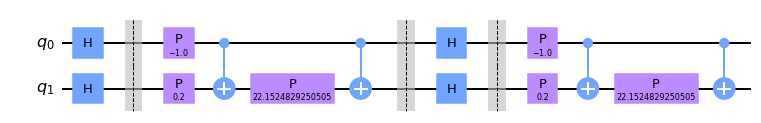

In [15]:
x = [-0.5,0.1]

xcod = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear', insert_barriers=True)
circuito = xcod.bind_parameters(x)
circuito.decompose().draw(output='mpl')

Ahora, un circuito $\mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) $ para dos vectores ejemplo usando `ZZFeatureMap` sería: 

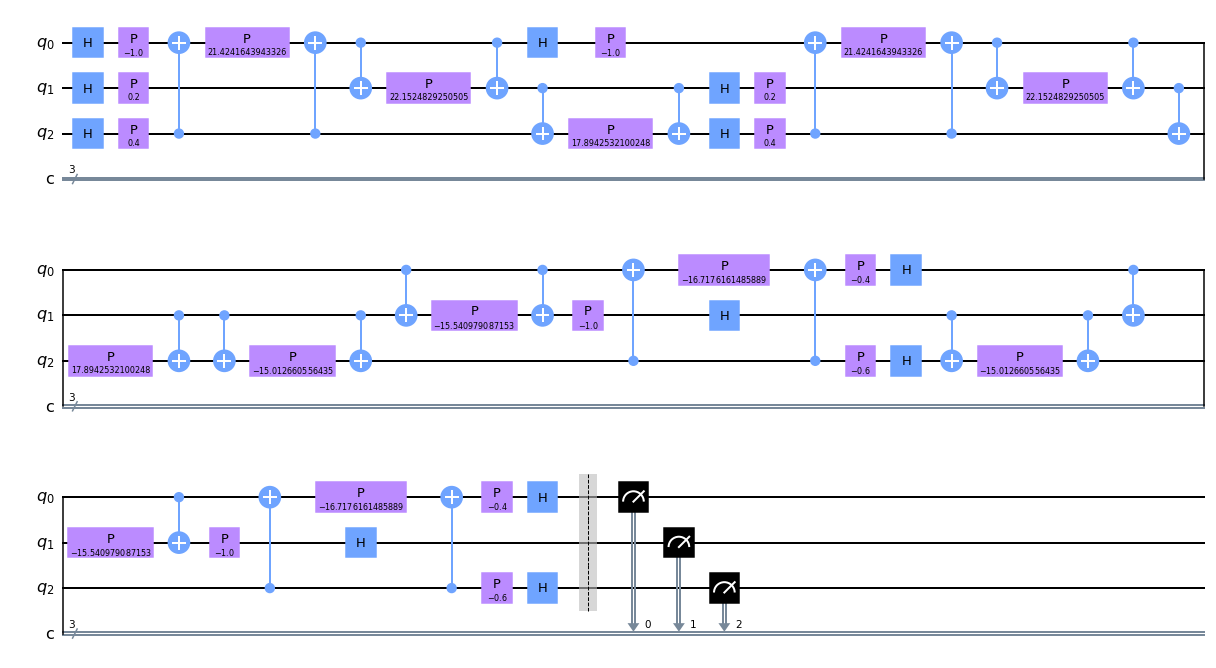

In [16]:
x1 = [-0.5,0.1,.2]
y1 = [0.2,0.5,.3]

zz_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='circular', insert_barriers=False)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

xycod = zz_kernel.construct_circuit(x1, y1)
xycod.decompose().decompose().draw(output='mpl')

También podemos jugar con las compuertas de esta transformación. Por ejemplo, si hacemos que $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

Que se visualiza:

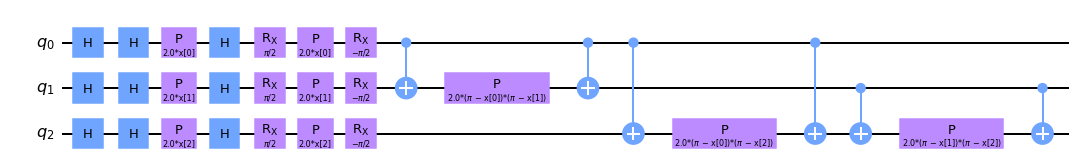

In [17]:
pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli.decompose().draw('mpl')

Procedamos entonces crear una Matriz de Gram, que se utilizará a continuación para entrenar un SVM clásica. 

In [18]:
#Reducir dimensiones
n_dim = 4
pca = PCA(n_components=n_dim).fit(entrenamiento)
pca = PCA(n_components=n_dim).fit(prueba)
entrenamiento = pca.transform(entrenamiento)
prueba = pca.transform(prueba)

In [19]:
zzgram_train = zz_kernel.evaluate(x_vec=entrenamiento)
zzgram_test = zz_kernel.evaluate(x_vec=prueba, y_vec=entrenamiento)
print(zzgram_train.shape)
print(zzgram_test.shape)

(100, 100)
(20, 100)


In [20]:
zz_svc = SVC(kernel='precomputed')
zz_svc.fit(zzgram_train, entrenamiento_tag)
zz_score = zz_svc.score(zzgram_test, prueba_tag)


print(f'ZZ precisión: {zz_score}')


ZZ precisión: 0.6


In [21]:
Pauli_map = PauliFeatureMap(feature_dimension=3, reps=2, paulis = ['X', 'Y', 'ZZ'])
Pauli_kernel = QuantumKernel(feature_map=Pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

z_map = ZFeatureMap(feature_dimension=n_dim, reps=2)
z_kernel = QuantumKernel(feature_map=z_map, quantum_instance=Aer.get_backend('statevector_simulator'))

In [22]:
gram_Pauli = Pauli_kernel.evaluate(x_vec=entrenamiento)
gram_test_Pauli = Pauli_kernel.evaluate(x_vec=prueba, y_vec=entrenamiento)

gram_train_z = z_kernel.evaluate(x_vec=entrenamiento)
gram_test_z = z_kernel.evaluate(x_vec=prueba, y_vec=entrenamiento)

In [23]:
p_svc = SVC(kernel='precomputed')
p_svc.fit(gram_Pauli, entrenamiento_tag)
p_score = p_svc.score(gram_test_Pauli, prueba_tag)

print(f'Pauli XYZZ precisión: {p_score}')

pc_svc = SVC(kernel='precomputed')
pc_svc.fit(gram_train_z, entrenamiento_tag)
pc_score = pc_svc.score(gram_test_z, prueba_tag)

print(f'Z precisión: {pc_score}')

Pauli XYZZ precisión: 0.6
Z precisión: 0.8
